# Filtering out the data from 2016 to 2020

In [ ]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)

file_name = "../artifacts/data_ingestion/lfm_2b/listening-events.tsv"
prefix_path = "../artifacts/data_ingestion/lfm_2b/filter"
chunksize = 10**8
min_play_date = pd.to_datetime("2016-01-01 00:00:00")
columns = ["user_id", "track_id", "timestamp"]

chunk_index = 0
for chunk in pd.read_csv(file_name, sep="\t", chunksize=chunksize):
    logging.info(f"""reading from {chunk.index.min()} to {chunk.index.max()}""")
    chunk["timestamp"] = pd.to_datetime(chunk["timestamp"], format="%Y-%m-%d %H:%M:%S")
    chunk = chunk.loc[(chunk["timestamp"] >= min_play_date), :]
    if len(chunk) > 0:
        logging.info(f"""writing from {chunk.index.min()} to {chunk.index.max()}""")

        chunk_path = os.path.join(prefix_path, f"""{int(chunk_index)}.parquet""")
        chunk = chunk[columns]
        chunk.to_parquet(chunk_path, index=False)
        logging.info(f"""writing chunk to {chunk_path} finished""")
        chunk_index += 1
    logging.info(f"""#################################""")

INFO:root:reading from 0 to 99999999
INFO:root:#################################
INFO:root:reading from 100000000 to 199999999
INFO:root:writing from 110527504 to 110527504
INFO:root:writing chunk to ../artifacts/data_ingestion/lfm_2b/filter\0.parquet finished
INFO:root:#################################
INFO:root:reading from 200000000 to 299999999
INFO:root:#################################
INFO:root:reading from 300000000 to 399999999
INFO:root:writing from 392872063 to 392872063
INFO:root:writing chunk to ../artifacts/data_ingestion/lfm_2b/filter\1.parquet finished
INFO:root:#################################
INFO:root:reading from 400000000 to 499999999
INFO:root:#################################
INFO:root:reading from 500000000 to 599999999
INFO:root:writing from 511284180 to 511284180
INFO:root:writing chunk to ../artifacts/data_ingestion/lfm_2b/filter\2.parquet finished
INFO:root:#################################
INFO:root:reading from 600000000 to 699999999
INFO:root:writing fro

# Step 1: Counting the number of tracks

In [4]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)

prefix_path = "../artifacts/data_ingestion/lfm_2b/filter"
track_counts = dict()

for i in range(100):
    chunk_path = os.path.join(prefix_path, f"""{int(i)}.parquet""")
    if os.path.exists(chunk_path):
        logging.info(f"""reading and counting tracks from chunk {chunk_path}""")
        chunk_data = pd.read_parquet(chunk_path)

        counts = chunk_data["track_id"].value_counts().to_dict()
        track_counts.update(counts)
track_df = pd.DataFrame(list(track_counts.items()), columns=["track_id", "count"])
track_df.head()

INFO:root:reading and counting tracks from chunk ../artifacts/data_ingestion/lfm_2b/filter\0.parquet
INFO:root:reading and counting tracks from chunk ../artifacts/data_ingestion/lfm_2b/filter\1.parquet
INFO:root:reading and counting tracks from chunk ../artifacts/data_ingestion/lfm_2b/filter\2.parquet
INFO:root:reading and counting tracks from chunk ../artifacts/data_ingestion/lfm_2b/filter\3.parquet
INFO:root:reading and counting tracks from chunk ../artifacts/data_ingestion/lfm_2b/filter\4.parquet
INFO:root:reading and counting tracks from chunk ../artifacts/data_ingestion/lfm_2b/filter\5.parquet
INFO:root:reading and counting tracks from chunk ../artifacts/data_ingestion/lfm_2b/filter\6.parquet
INFO:root:reading and counting tracks from chunk ../artifacts/data_ingestion/lfm_2b/filter\7.parquet
INFO:root:reading and counting tracks from chunk ../artifacts/data_ingestion/lfm_2b/filter\8.parquet
INFO:root:reading and counting tracks from chunk ../artifacts/data_ingestion/lfm_2b/filter\

,track_id,count
0,433419,1
1,6990909,1
2,40855852,33
3,43046932,4
4,40071241,750


# Mitigating the single tracks

In [ ]:
# elimination of single tracks from chunks
logging.info(f"""Total number of tracks before elimination: {len(track_df)}""")
mask = track_df["count"] > 1
track_df = track_df.loc[mask, :]
logging.info(f"""Total number of tracks before elimination: {len(track_df)}""")

INFO:root:Total number of tracks before elimination: 23100188
INFO:root:Total number of tracks before elimination: 10144168


In [6]:
import numpy as np
number_tracks = track_df["track_id"].nunique()
tracks_id_map = dict(zip(track_df["track_id"].unique(), np.arange(number_tracks)))

In [ ]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)

prefix_path = "../artifacts/data_ingestion/lfm_2b/filter"
track_set = set(track_df["track_id"].unique())

new_chunk_index = 0
for i in range(100):
    chunk_path = os.path.join(prefix_path, f"""{int(i)}.parquet""")
    if os.path.exists(chunk_path):
        logging.info(f"""reading and filtring chunk from {chunk_path}""")
        chunk_data = pd.read_parquet(chunk_path)
        is_in_mask = chunk_data["track_id"].isin(track_set)
        chunk_data = chunk_data.loc[is_in_mask, :]
        if len(chunk_data) > 1:

            # for memory efficiency
            chunk_data["track_id"] = chunk_data["track_id"].map(tracks_id_map)
            chunk_data["track_id"] = chunk_data['track_id'].astype('uint32')
            chunk_data["user_id"] = chunk_data['user_id'].astype('uint32')

            new_chunk_path = os.path.join(prefix_path, f"""{int(i)}_new.parquet""")
            logging.info(f"""writing new chunk to {new_chunk_path}""")
            chunk_data.to_parquet(new_chunk_path, index=False)
            new_chunk_index += 1

INFO:root:reading and filtring chunk from ../artifacts/data_ingestion/lfm_2b/filter\0.parquet
INFO:root:reading and filtring chunk from ../artifacts/data_ingestion/lfm_2b/filter\1.parquet
INFO:root:reading and filtring chunk from ../artifacts/data_ingestion/lfm_2b/filter\2.parquet
INFO:root:reading and filtring chunk from ../artifacts/data_ingestion/lfm_2b/filter\3.parquet
INFO:root:reading and filtring chunk from ../artifacts/data_ingestion/lfm_2b/filter\4.parquet
INFO:root:writing new chunk to ../artifacts/data_ingestion/lfm_2b/filter\4_new.parquet
INFO:root:reading and filtring chunk from ../artifacts/data_ingestion/lfm_2b/filter\5.parquet
INFO:root:writing new chunk to ../artifacts/data_ingestion/lfm_2b/filter\5_new.parquet
INFO:root:reading and filtring chunk from ../artifacts/data_ingestion/lfm_2b/filter\6.parquet
INFO:root:writing new chunk to ../artifacts/data_ingestion/lfm_2b/filter\6_new.parquet
INFO:root:reading and filtring chunk from ../artifacts/data_ingestion/lfm_2b/filt

# Finding data from 2016-2019

In [ ]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)

prefix_path = "../artifacts/data_ingestion/lfm_2b/filter"
list_of_dataframes = []
columns = ["user_id", "track_id"]
date_2019 = pd.to_datetime("2019-01-01 00:00:00")

for i in range(100):
    chunk_path = os.path.join(prefix_path, f"""{int(i)}_new.parquet""")
    if os.path.exists(chunk_path):
        logging.info(f"""reading chunk from {chunk_path}""")
        chunk_data = pd.read_parquet(chunk_path)
        mask = (chunk_data["timestamp"] < date_2019)
        chunk_data = chunk_data.loc[mask, columns]
        list_of_dataframes.append(chunk_data)

logging.info(f"""Writing data from 2016 to 2019 to""")
event_data_2016_2019 = pd.concat(list_of_dataframes, ignore_index=True)  
event_data_2016_2019.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/from_2016_2019.parquet", index=False)

INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\4_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\5_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\6_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\7_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\8_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\9_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\10_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\11_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\12_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\13_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\14_new.parquet


# Finding Data from 2019 to 2020

In [4]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)

prefix_path = "../artifacts/data_ingestion/lfm_2b/filter"
list_of_dataframes = []
columns = ["user_id", "track_id"]
date_2019 = pd.to_datetime("2019-01-01 00:00:00")
date_2020 = pd.to_datetime("2020-01-01 00:00:00")


for i in range(100):
    chunk_path = os.path.join(prefix_path, f"""{int(i)}_new.parquet""")
    if os.path.exists(chunk_path):
        logging.info(f"""reading chunk from {chunk_path}""")
        chunk_data = pd.read_parquet(chunk_path)
        mask = (chunk_data["timestamp"] >= date_2019) & (chunk_data["timestamp"] < date_2020)
        chunk_data = chunk_data.loc[mask, columns]
        list_of_dataframes.append(chunk_data)

logging.info(f"""Writing data from 2019 to 2020 to""")
event_data_2019_2020 = pd.concat(list_of_dataframes, ignore_index=True)
event_data_2019_2020.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/from_2019_2020.parquet", index=False)


INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\4_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\5_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\6_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\7_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\8_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\9_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\10_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\11_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\12_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\13_new.parquet
INFO:root:reading chunk from ../artifacts/data_ingestion/lfm_2b/filter\14_new.parquet
INFO:root:Writing data from 2019 to 2020 to


# Transforming data into one chunk

In [8]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)

prefix_path = "../artifacts/data_ingestion/lfm_2b/filter"
list_of_dataframes = []
track_counts = dict()
columns = ["user_id", "track_id"]

for i in range(100):
    chunk_path = os.path.join(prefix_path, f"""{int(i)}_new.parquet""")
    if os.path.exists(chunk_path):
        logging.info(f"""reading chunk from {chunk_path}""")
        chunk_data = pd.read_parquet(chunk_path)
        chunk_data = chunk_data[columns]
        list_of_dataframes.append(chunk_data)
        
logging.info(f"""concatinating all chunks""")
event_data = pd.concat(list_of_dataframes, ignore_index=True)
event_data.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/from_2016.parquet", index=False)

INFO:root:reading and chunk from ../artifacts/data_ingestion/lfm_2b/filter\4_new.parquet
INFO:root:reading and chunk from ../artifacts/data_ingestion/lfm_2b/filter\5_new.parquet
INFO:root:reading and chunk from ../artifacts/data_ingestion/lfm_2b/filter\6_new.parquet
INFO:root:reading and chunk from ../artifacts/data_ingestion/lfm_2b/filter\7_new.parquet
INFO:root:reading and chunk from ../artifacts/data_ingestion/lfm_2b/filter\8_new.parquet
INFO:root:reading and chunk from ../artifacts/data_ingestion/lfm_2b/filter\9_new.parquet
INFO:root:reading and chunk from ../artifacts/data_ingestion/lfm_2b/filter\10_new.parquet
INFO:root:reading and chunk from ../artifacts/data_ingestion/lfm_2b/filter\11_new.parquet
INFO:root:reading and chunk from ../artifacts/data_ingestion/lfm_2b/filter\12_new.parquet
INFO:root:reading and chunk from ../artifacts/data_ingestion/lfm_2b/filter\13_new.parquet
INFO:root:reading and chunk from ../artifacts/data_ingestion/lfm_2b/filter\14_new.parquet
INFO:root:concat

# Creation of intraction data

### 2016 to 2019

In [1]:
import pandas as pd
import logging
import os
import gc

logging.getLogger().setLevel(logging.INFO)

event_data_2016_2019 = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/from_2016_2019.parquet")
event_data_2016_2019['user_id'] = event_data_2016_2019['user_id'].astype('uint32')
event_data_2016_2019['track_id'] = event_data_2016_2019['track_id'].astype('uint32')

intraction_data_2016_2019 = event_data_2016_2019.groupby(["user_id", "track_id"]).size().reset_index(name="count")
intraction_data_2016_2019.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/intraction_2016_2019.parquet", index=False)

### 2019 to 2020

In [6]:
import pandas as pd
import logging
import os
import gc

logging.getLogger().setLevel(logging.INFO)

event_data_2019_2020 = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/from_2019_2020.parquet")
event_data_2019_2020['user_id'] = event_data_2019_2020['user_id'].astype('uint32')
event_data_2019_2020['track_id'] = event_data_2019_2020['track_id'].astype('uint32')

intraction_data_2019_2020 = event_data_2019_2020.groupby(["user_id", "track_id"]).size().reset_index(name="count")
intraction_data_2019_2020.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/intraction_2019_2020.parquet", index=False)

# Reading intractions and performing K core Filtering

In [2]:
def k_core_filtering(inter_data, k_item, k_user):
    logging.info(f"""Remaining items: {inter_data.track_id.nunique()}, Remaining users: {inter_data.user_id.nunique()} """)
    while True:
        start_size = len(inter_data)

        # Item pass
        track_counts = inter_data.track_id.value_counts()
        tracks_above = set(track_counts[track_counts >= k_item].index)
        inter_data = inter_data[inter_data.track_id.isin(tracks_above)]
        logging.info(f"""Remaining items: {inter_data.track_id.nunique()}, Remaining users: {inter_data.user_id.nunique()} """)

        # User pass
        user_counts = inter_data.user_id.value_counts()
        user_above = set(user_counts[user_counts >= k_user].index)
        inter_data = inter_data[inter_data.user_id.isin(user_above)]
        logging.info(f"""Remaining items: {inter_data.track_id.nunique()}, Remaining users: {inter_data.user_id.nunique()} """)
        logging.info(f"""##########################################""")

        if len(inter_data) == start_size:
            print("Exiting...")
            break
    return inter_data

### 2016 to 2019

In [3]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)
k_item = 5
k_user = 5

intraction_data_2016_2019 = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/intraction_2016_2019.parquet")
intraction_data_2016_2019 = k_core_filtering(intraction_data_2016_2019, k_item, k_user)
intraction_data_2016_2019.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/intraction_2016_2019_filtered.parquet", index=False)

INFO:root:Remaining items: 8836865, Remaining users: 35519 
INFO:root:Remaining items: 2121368, Remaining users: 35393 
INFO:root:Remaining items: 2121368, Remaining users: 34055 
INFO:root:##########################################
INFO:root:Remaining items: 2121311, Remaining users: 34055 
INFO:root:Remaining items: 2121311, Remaining users: 34054 
INFO:root:##########################################
INFO:root:Remaining items: 2121310, Remaining users: 34054 
INFO:root:Remaining items: 2121310, Remaining users: 34054 
INFO:root:##########################################
INFO:root:Remaining items: 2121310, Remaining users: 34054 
INFO:root:Remaining items: 2121310, Remaining users: 34054 
INFO:root:##########################################


Exiting...


### 2019 - 2020

In [4]:
import pandas as pd
import logging
import os

logging.getLogger().setLevel(logging.INFO)
k_item = 5
k_user = 5

intraction_data_2019_2020 = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/intraction_2019_2020.parquet")
intraction_data_2019_2020 = k_core_filtering(intraction_data_2019_2020, k_item, k_user)
intraction_data_2019_2020.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/intraction_2019_2020_filtered.parquet", index=False)

INFO:root:Remaining items: 5279680, Remaining users: 18213 
INFO:root:Remaining items: 1100313, Remaining users: 18078 
INFO:root:Remaining items: 1100313, Remaining users: 17488 
INFO:root:##########################################
INFO:root:Remaining items: 1100255, Remaining users: 17488 
INFO:root:Remaining items: 1100255, Remaining users: 17488 
INFO:root:##########################################
INFO:root:Remaining items: 1100255, Remaining users: 17488 
INFO:root:Remaining items: 1100255, Remaining users: 17488 
INFO:root:##########################################


Exiting...


# Filtering the Users who are in both first and second frame

In [1]:
import pandas as pd
import logging
import os
logging.getLogger().setLevel(logging.INFO)

intraction_data_2016_2019 = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/intraction_2016_2019_filtered.parquet")
intraction_data_2019_2020 = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/filter/intraction_2019_2020_filtered.parquet")

user_set_2016_2019 = set(intraction_data_2016_2019["user_id"].unique())
user_set_2019_2020 = set(intraction_data_2019_2020["user_id"].unique())
intersection_set = user_set_2016_2019.intersection(user_set_2019_2020)

logging.info(f"""Available items: {intraction_data_2016_2019.track_id.nunique()}, Available users: {intraction_data_2016_2019.user_id.nunique()} """)
mask = intraction_data_2016_2019["user_id"].isin(intersection_set)
intraction_data_2016_2019 = intraction_data_2016_2019.loc[mask]
intraction_data_2016_2019.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/intraction_2016_2019_filtered.parquet")
logging.info(f"""Remaining items: {intraction_data_2016_2019.track_id.nunique()}, Remaining users: {intraction_data_2016_2019.user_id.nunique()} """)
logging.info("#####################################################")

logging.info(f"""Available items: {intraction_data_2019_2020.track_id.nunique()}, Available users: {intraction_data_2019_2020.user_id.nunique()} """)
mask = intraction_data_2019_2020["user_id"].isin(intersection_set)
intraction_data_2019_2020 = intraction_data_2019_2020.loc[mask]
intraction_data_2019_2020.to_parquet("../artifacts/data_ingestion/lfm_2b/filter/intraction_2019_2020_filtered.parquet")
logging.info(f"""Remaining items: {intraction_data_2019_2020.track_id.nunique()}, Remaining users: {intraction_data_2019_2020.user_id.nunique()} """)


INFO:root:Available items: 2121310, Available users: 34054 
INFO:root:Remaining items: 2121189, Remaining users: 17008 
INFO:root:#####################################################
INFO:root:Available items: 1100255, Available users: 17488 
INFO:root:Remaining items: 1100255, Remaining users: 17008 


In [2]:
display(intraction_data_2016_2019.head())
display(intraction_data_2019_2020.head())

,user_id,track_id,count
0,0,3,1
1,0,4,1
2,0,44,2
3,0,45,2
4,0,49,1


,user_id,track_id,count
0,0,208,1
1,0,420,1
2,0,588,1
3,0,661,1
4,0,1176,1


In [ ]:
user_data = pd.read_csv("../artifacts/data_ingestion/lfm_2b/users_corrected.tsv", sep="\t")
user_data["creation_time"] = pd.to_datetime(user_data["creation_time"])
user_data.rename(columns={"user_id": "user", "age_on_2013_10_31": "age"}, inplace=True)
user_data.head()
print(f"""The number of unique users before filtering: {user_data["user"].nunique()}""")

# filtering out the most recent users
min_creation_date = pd.Timestamp("2008-01-01")
user_data = user_data[user_data["creation_time"] >= min_creation_date]

# filtering out the valid users
user_data = user_data[
    (
        (user_data["gender"].isin(["m", "f"]))
        & (
            user_data["country"].notna()
            & (user_data["country"].str.strip() != "")
            & (user_data["country"].str.lower() != "nan")
        )
        & ((user_data["age"] != -1) & (user_data["age_valid"] == True))
    )
]
user_data = user_data[["user", "gender"]]
print(f"""The number of unique users after filtering: {user_data["user"].nunique()}""")
user_data.to_parquet("../artifacts/data_ingestion/lfm_2b/users_filtered.tsv", index=False)
user_data.head()

The number of unique users before filtering: 120322
The number of unique users after filtering: 29018


,user,gender
16321,17630,f
16323,17638,f
16327,17654,f
16332,17674,f
16334,17682,m


# Filtering the valid users in the intraction data

In [ ]:
import pandas as pd
import logging 
logging.getLogger().setLevel(logging.INFO)

29018

In [ ]:
user_data = pd.read_parquet("../artifacts/data_ingestion/lfm_2b/users_filtered.tsv")
intraction_data = pd.read_csv("../artifacts/data_ingestion/lfm_2b/listening-counts.tsv", sep="\t", nrows=1000)
intraction_data.rename(columns={"user_id": "user", "track_id": "item", "count": "rating"}, inplace=True)

logging.info(f"The Size of intraction data before filtering {len(intraction_data)}")
print(f"""The number of unique users before filtering: {intraction_data["user_id"].nunique()}""")
print(f"""The number of unique items before: {intraction_data["track_id"].nunique()}""")

valid_users = set(user_data["user"].unique())
intraction_data = intraction_data[intraction_data["user"].isin(valid_users)]

logging.info(f"The Size of intraction data before filtering {len(intraction_data)}")
print(f"""The number of unique users before filtering: {intraction_data["user_id"].nunique()}""")
print(f"""The number of unique items before: {intraction_data["track_id"].nunique()}""")

,user_id,track_id,count
0,92915,26719936,1
1,92915,4271407,1
2,92915,4606511,1
3,92915,8966085,1
4,92915,12290897,1
...,...,...,...
995,92915,45070225,1
996,92915,13528742,2
997,92915,40912527,1
998,92915,4946499,7


In [16]:
intraction_data = pd.read_csv("../artifacts/data_ingestion/lfm_2b/listening-events.tsv", sep="\t", nrows=1000)
intraction_data.rename({"user_id": "user", "track_id": "item"}, inplace=True)
intraction_data.head()

,user_id,track_id,album_id,timestamp
0,51549,27265012,19250819,2013-11-23 14:22:38
1,51549,27265012,19250819,2013-11-23 14:17:22
2,51549,27265012,19250819,2013-11-23 14:12:05
3,51549,27265012,19250819,2013-11-23 13:25:08
4,51549,27265012,19250819,2013-11-23 13:19:51


### Filtering out the unique counts

In [ ]:

# Filter rows with count > 1
intraction_data = intraction_data[intraction_data['count'] > 1]
num_unique_users = intraction_data['user'].nunique()
num_unique_tracks = intraction_data['item'].nunique()

logging.info(f"Unique user_id count after filtering: {num_unique_users}")
logging.info(f"Unique track_id count after filtering: {num_unique_tracks}")


INFO:root:Unique user_id count after filtering: 119779
INFO:root:Unique track_id count after filtering: 28365299


In [ ]:
from tools import k_core_filtering
intraction_data = k_core_filtering(intraction_data)


In [ ]:
intraction_data = pd.read_csv("../artifacts/data_ingestion/lfm_2b/listening-counts.tsv", sep="\t")
print("Users {} - Items {}".format(intraction_data.user_id.nunique(), intraction_data.track_id.nunique()))

Users 120322 - Items 50813373


In [12]:
intraction_data.head()

,user_id,track_id,count
0,92915,26719936,1
1,92915,4271407,1
2,92915,4606511,1
3,92915,8966085,1
4,92915,12290897,1


In [2]:
import numpy as np

proportions = [0.8, 0.2]

ordered_labels = {}
random_labels = {}

labels = ["train", "validation", "test"]
for user_id, group in ml_dataset.groupby(["user"]):
    n = len(group)
    group_sorted = group.sort_values(by="time", ascending=True)
    split_indices = [int(n * p) for p in proportions]
    split_indices[-1] = n - sum(split_indices[:-1])

    start_index = 0
    shuffled_index = group.sample(frac=1).index
    for i, n_instance in enumerate(split_indices):
        end_index = start_index + n_instance

        split_ordered_idx = group_sorted[start_index:end_index].index
        split_random_index = shuffled_index[start_index:end_index]

        labels_array = np.repeat(labels[i], n_instance)
        ordered_labels.update(dict(zip(split_ordered_idx, labels_array)))
        random_labels.update(dict(zip(split_random_index, labels_array)))

        start_index = end_index

ml_dataset["random_split"] = ml_dataset.index.map(random_labels)
ml_dataset["time_split"] = ml_dataset.index.map(ordered_labels)
ml_dataset = ml_dataset.sort_values(by=["user", "time"], ignore_index=True)
ml_dataset.head(50)


,user,item,rating,time,random_split,time_split
0,1,3186,4,978300019,train,train
1,1,1270,5,978300055,validation,train
2,1,1721,4,978300055,validation,train
3,1,1022,5,978300055,validation,train
4,1,2340,3,978300103,train,train
5,1,1836,5,978300172,train,train
6,1,3408,4,978300275,train,train
7,1,2804,5,978300719,train,train
8,1,1207,4,978300719,train,train
9,1,1193,5,978300760,train,train


In [3]:
from tools import generate_user_item_matrix
from tools import group_items_based_popularity
from tools import create_user_item_map

user_map, item_map = create_user_item_map(ml_dataset)
sparse_matrix = generate_user_item_matrix(ml_dataset, user_map, item_map)
item_groups = group_items_based_popularity(sparse_matrix.toarray(), proportions=[0.2, 0.6, 0.2])

In [4]:
index_to_item_id = {v: k for k, v in item_map.items()}
group_df = pd.DataFrame({"item_index": np.arange(len(item_groups)), "item_popularity_group": item_groups})
group_df["item"] = group_df["item_index"].map(index_to_item_id)
ml_dataset = ml_dataset.merge(group_df[["item", "item_popularity_group"]], on="item", how="left")

In [5]:
mask_random = ml_dataset["random_split"] == "train"
train_data_random = ml_dataset.loc[mask_random, :].copy()
valid_data_random = ml_dataset.loc[~mask_random, :].copy()

train_user_item_random = generate_user_item_matrix(train_data_random, user_map, item_map)
valid_user_item_random = generate_user_item_matrix(valid_data_random, user_map, item_map)

display(train_user_item_random.shape)
display(valid_user_item_random.shape)

(6040, 3706)

(6040, 3706)

In [6]:
from reylearn.metrics.probability import jsd, kl_divergence
from tools import calculate_pc_qc

p_c_random, q_c_random = calculate_pc_qc(train_user_item_random.toarray(), valid_user_item_random.toarray(), item_groups)
user_jsd_random = jsd(p_c_random, q_c_random)
user_jsd_random.mean()

np.float64(0.03972748382181238)

In [7]:
mask_ordered = ml_dataset["time_split"] == "train"
train_data_ordered = ml_dataset.loc[mask_ordered, :].copy()
valid_data_ordered = ml_dataset.loc[~mask_ordered, :].copy()

train_user_item_ordered = generate_user_item_matrix(train_data_ordered, user_map, item_map)
valid_user_item_ordered = generate_user_item_matrix(valid_data_ordered, user_map, item_map)

display(train_user_item_ordered.shape)
display(valid_user_item_ordered.shape)

(6040, 3706)

(6040, 3706)

In [8]:
from reylearn.metrics.probability import jsd, kl_divergence
from tools import calculate_pc_qc

p_c_ordered, q_c_ordered = calculate_pc_qc(train_user_item_ordered.toarray(), valid_user_item_ordered.toarray(), item_groups)
user_jsd_ordered = jsd(p_c_ordered, q_c_ordered)
user_jsd_ordered.mean()

np.float64(0.07773823607704947)

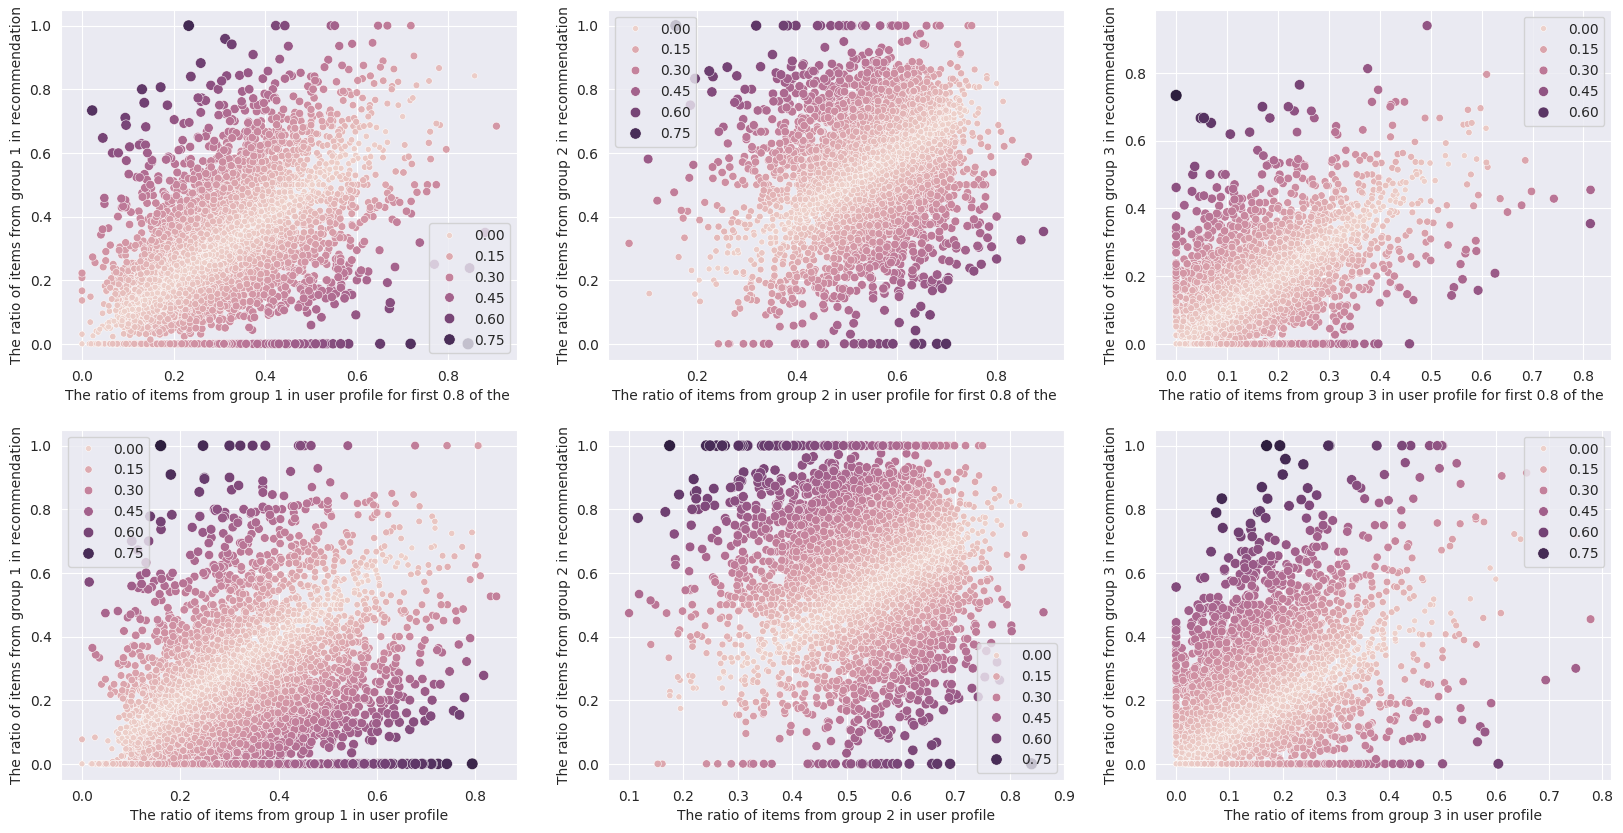

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    for i in range(3):
        diff_random = np.abs(p_c_random[:, i] - q_c_random[:, i])
        diff_ordered = np.abs(p_c_ordered[:, i] - q_c_ordered[:, i])
        ax_random = axes.ravel()[i]
        ax_ordered = axes.ravel()[i + 3]

        sns.scatterplot(x=p_c_random[:, i], y=q_c_random[:, i], size=diff_random, hue=diff_random, ax=ax_random)
        sns.scatterplot(x=p_c_ordered[:, i], y=q_c_ordered[:, i], size=diff_ordered, hue=diff_ordered, ax=ax_ordered)

        ax_random.set_xlabel(f"""The ratio of items from group {i+1} in user profile for first 0.8 of the """)
        ax_random.set_ylabel(f"""The ratio of items from group {i+1} in recommendation""")

        ax_ordered.set_xlabel(f"""The ratio of items from group {i+1} in user profile""")
        ax_ordered.set_ylabel(f"""The ratio of items from group {i+1} in recommendation""")

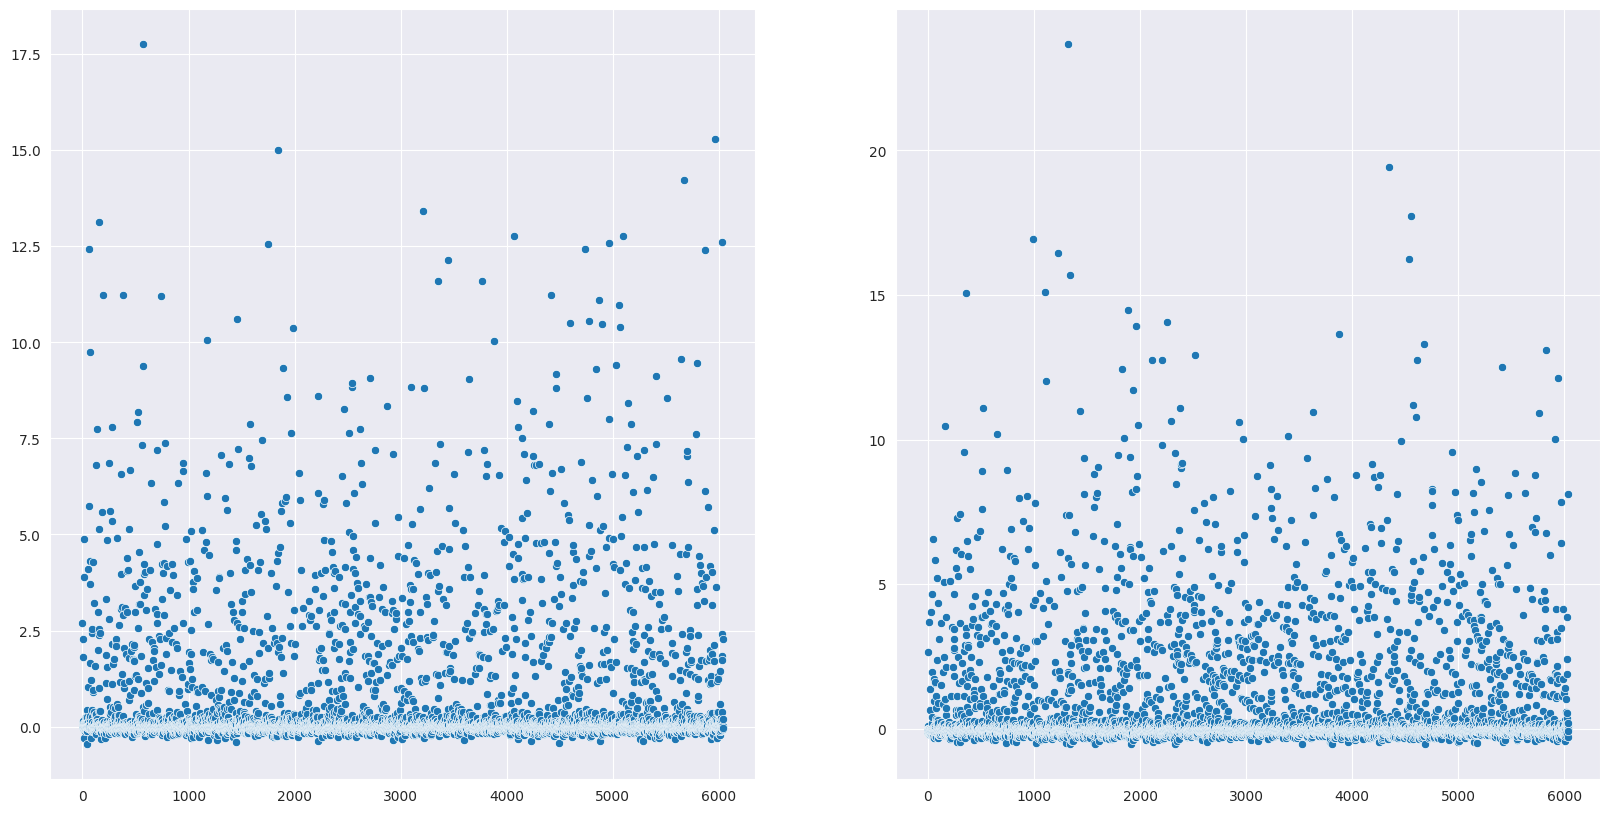

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

kl_ordered = kl_divergence(p_c_ordered[:, 2].reshape(-1, 1), q_c_ordered[:, 2].reshape(-1, 1))
kl_random = kl_divergence(p_c_random[:, 2].reshape(-1, 1), q_c_random[:, 2].reshape(-1, 1))


with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    sns.scatterplot(x=np.arange(len(kl_random)), y=kl_random, ax=axes.ravel()[0])
    sns.scatterplot(x=np.arange(len(kl_ordered)), y=kl_ordered, ax=axes.ravel()[1])

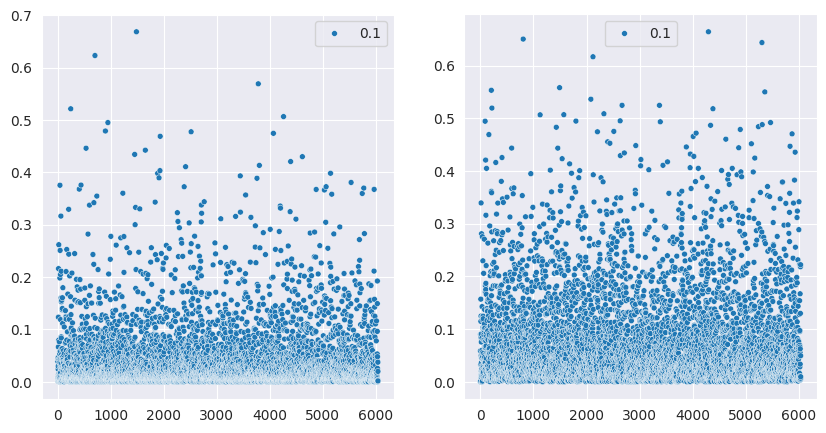

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

jsd_ordered = jsd(p_c_ordered, q_c_ordered)
jsd_random = jsd(p_c_random, q_c_random)


with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    sns.scatterplot(x=np.arange(len(kl_random)), y=jsd_random, size=0.1, ax=axes.ravel()[0])
    sns.scatterplot(x=np.arange(len(kl_ordered)), y=jsd_ordered, size=0.1, ax=axes.ravel()[1])